#### Do standard imports for Python Data Work

In [4]:
import sys, os
from numpy import *
from matplotlib.pyplot import *
%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 100

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Add working paths

In [50]:
from os.path import expanduser
import re
home = expanduser("~")
vc_dir = "Dropbox/Data Scrape of VC/"
training_dir = "NLP Training Set"

full_input_dir = os.path.join(home, vc_dir, training_dir)

## Extract all labels from training data

In [70]:
all_files = os.listdir(full_input_dir)
full_path = [os.path.join(full_input_dir, x) for x in all_files ]
files = [x for x in full_path if os.path.isfile(x)]
regex = "\[\[(.*?)\]\]"
labels = []
match_objs = []
for f in files:
    with open(f, 'r') as in_f:
        for m in re.finditer(regex, in_f.read()):
            current_tag = m.group()
            labels += [current_tag]
            match_objs += [m]
            
stripped_labels = [x[2:-2] for x in labels]
share_tags = [x.split(":")[0] for x in stripped_labels]
count_tags = [x.split(":")[1] for x in stripped_labels]
tags_to_count = {}
for label in stripped_labels:
    name, _ = label.split(":")
    count = tags_to_count.get(name, 0)
    tags_to_count[name] = count + 1

#### Here are some stats about the current labeled dataset

In [71]:
print "===== [Stats on the training data] ====="
print "Number of documents: %i" % len(files)
print "Number of training samples: %i" % len(stripped_labels)
print "Number of unique labels: %i" % len(set(share_tags))
print "%s" % "\n ".join([str(x) for x in sorted(tags_to_count.items(), key=lambda x: x[1])])


===== [Stats on the training data] =====
Number of documents: 69
Number of training samples: 366
Number of unique labels: 36
('Series FV Preferred Shares', 1)
 ('Series C2 Preferred Shares', 1)
 ('Series Seed1 Preferred Shares', 1)
 ('Series E1 Preferred Shares', 1)
 ('Series 5B2 Preferred Shares', 1)
 ('Series AA Preferred Shares', 1)
 ('Series F1 Preferred Shares', 1)
 ('Series 5 Preferred Shares', 1)
 ('Series 4 Preferred Shares', 1)
 ('Series 5A Preferred Shares', 1)
 ('Series 3 Preferred Shares', 1)
 ('Series Z Preferred Shares', 1)
 ('Series BB Preferred Shares', 1)
 ('Series 5B1 Preferred Shares', 1)
 ('Series Junior Preferred Shares', 1)
 ('Series FT Preferred Shares', 1)
 ('Series 2 Preferred Shares', 2)
 ('Series 1 Preferred Shares', 3)
 ('Series Seed Preferred Shares', 3)
 ('Series A3 Preferred Shares', 3)
 ('Series C1 Preferred Shares', 3)
 ('Series B2 Preferred Shares', 4)
 ('Series E Preferred Shares', 4)
 ('Series D1 Preferred Shares', 4)
 ('Series A2 Preferred Shares', 

Tokenize each document by sentences, label each sentence as interesting or not (it's interesting if it has tags) and vectorize by three features. This will be used as training data for our decision tree for whether a sentence is interesting or not. 

Currently each sentence has three features that the decision tree will use. 
- Contains a number with commas
- Sentence Length
- Contains the word 'stock' or 'share'



In [196]:
from sentence import *
sentence_objs = []
features = [ContainsCommaNumber, SentenceLength, ContainsStockOrShare]

for f in files:
    with open(f, 'r') as in_f:
        raw_text = filter_ascii(in_f.read())
        
        # Create sentence objects: see sentence.py for the way this is done
        for s in parser.tokenize(raw_text):
            sentence_objs += [Sentence(s)]


sentence_vecs = [s.to_vector(features) for s in sentence_objs]
output_labels = [s.is_interesting_as_int() for s in sentence_objs]
print "Processed %i sentences" % len(sentence_objs)
print "   %i are interesting" % output_labels.count(1)


Processed 10057 sentences
   179 are interesting


====== [Training report] ======
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      6619
          1       0.94      0.92      0.93       119

avg / total       1.00      1.00      1.00      6738



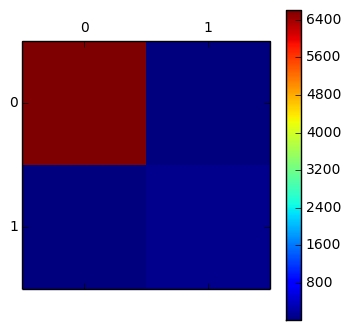

[[6612    7]
 [   9  110]]
====== [Test report] =====
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3259
          1       0.77      0.78      0.78        60

avg / total       0.99      0.99      0.99      3319



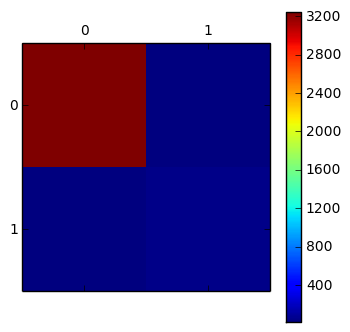

[[3245   14]
 [  13   47]]


In [207]:
import pylab as pl
from sklearn import tree, cross_validation
from sklearn.metrics import classification_report, confusion_matrix
clf = tree.DecisionTreeClassifier()



v_train, v_test, out_train, out_test = cross_validation.train_test_split(sentence_vecs, output_labels, test_size=.33, random_state=0)
clf = clf.fit(v_train, out_train)
out_train_pred = clf.predict(v_train)
out_test_pred = clf.predict(v_test)

print "====== [Training report] ======"
print classification_report(out_train, out_train_pred)
cm_train = confusion_matrix(out_train, out_train_pred)
pl.matshow(cm_train)
pl.colorbar()
pl.show()
print cm_train

print "====== [Test report] ====="
print classification_report(out_test, out_test_pred)
cm_test = confusion_matrix(out_test, out_test_pred)
pl.matshow(cm_test)
pl.colorbar()
pl.show()
print cm_test

## Stage 1: Interesting Sentences

Vectorize each sentence, labelling it as interesting or not. Doing it using classification ('Interesting', 'Not') is a better long term approach because it allows for future labels to be added in addition to the stock data labelling. This might require new sentence level features to be added to `sentence.py`

# Testing Small Algorithms

#### Matching the labels within documents

In [10]:
s = "The Corporation will have the authority to issue 14,000,000[[Total Shares:14,000,000]] shares of capital stock, $0.0001 par value per share, of which 10,000,000[[Common Shares:10,000,000]] shares will be Common Stock and of which 4,000,000[[Preferred Shares:4,000,000]] shares will be Preferred Stock."

In [100]:
regex = "\[\[(.*?)\]\]"
running_length = 0
spans = []
for m in re.finditer(regex, s):
    sp = m.span()
    adjusted_pos = sp[0] - running_length
    spans += [adjusted_pos]
    running_length += sp[1] - sp[0]

print spans
without_tags = re.sub(regex, "", s)
print without_tags
print [without_tags[(x-10): x] for x in spans]


[59, 133, 184]
The Corporation will have the authority to issue 14,000,000 shares of capital stock, $0.0001 par value per share, of which 10,000,000 shares will be Common Stock and of which 4,000,000 shares will be Preferred Stock.
['14,000,000', '10,000,000', ' 4,000,000']


In [23]:
def insertChars(s, c, *indeces)
    """Insert character `c` at `indeces` in the string `s`"""
    splt = lambda s, i, : 


'[[Preferred Shares:4,000,000]]'

'abc|de|f|ghijk'

#### Tokenizing documents by sentences and matching integers

In [61]:
import nltk
parser = nltk.data.load('tokenizers/punkt/english.pickle')

In [115]:
sample_paragraph = """
RTICLE IV
Effective upon filing of this Amended and Restated Certificate of Incorporation with the Delaware Secretary of State, and prior to the issuance of any shares of Preferred Stock each currently outstanding share of Common Stock will be converted and reconstituted into 8.78204 shares of Common Stock of the Corporation (the “Stock Split”). No fractional shares or scrip representing fractional shares will be issued in connection with such Stock Split. If, after the aforementioned aggregation, the Stock Split would result in the issuance of any fractional share, the Corporation shall, in lieu of issuing any fractional share, pay cash equal to the product of such fraction multiplied by the Common Stock’s fair market value (as determined by the Board of Directors) on the date of conversion. All numbers of shares, and all amounts stated on a per share basis, contained in this Amended and Restated Certificate of Incorporation, are stated after giving effect to such Stock Split and no further adjustment shall be made as a consequence of such Stock Split.
The Corporation will have the authority to issue 14,000,000[[Total Shares:14,000,000]] shares of capital stock, $0.0001 par value per share, of which 10,000,000[[Common Shares:10,000,000]] shares will be Common Stock and of which 4,000,000[[Preferred Shares:4,000,000]] shares will be Preferred Stock.
11 7^1901? v5
"""

In [63]:
import string
filter_ascii = lambda s: filter(lambda x: x in string.printable, s)
clean_par = filter_ascii(sample_paragraph)

In [64]:
sentences = parser.tokenize(sample_paragraph)

*It's notable that the parser works pretty well. For instance, it does not split on the "." in "$0.0001 per share"*

In [68]:
print "\n ------ \n".join(sentences)


RTICLE IV
Effective upon filing of this Amended and Restated Certificate of Incorporation with the Delaware Secretary of State, and prior to the issuance of any shares of Preferred Stock each currently outstanding share of Common Stock will be converted and reconstituted into 8.78204 shares of Common Stock of the Corporation (the “Stock Split”).
 ------ 
No fractional shares or scrip representing fractional shares will be issued in connection with such Stock Split.
 ------ 
If, after the aforementioned aggregation, the Stock Split would result in the issuance of any fractional share, the Corporation shall, in lieu of issuing any fractional share, pay cash equal to the product of such fraction multiplied by the Common Stock’s fair market value (as determined by the Board of Directors) on the date of conversion.
 ------ 
All numbers of shares, and all amounts stated on a per share basis, contained in this Amended and Restated Certificate of Incorporation, are stated after giving effect 

#### NUMPY Scratch work

In [101]:
import numpy as np


In [114]:
flat_v = np.array([1, 2, 3])
tall_v = np.array([[1], [2], [3]])
reshape_v = tall_v.reshape(-1)
print flat_v.shape
print tall_v.shape
print reshape_v.shape[0]
print flat_v.reshape(-1).shape[0]

(3,)
(3, 1)
3
3


In [124]:
integer_regex = r'\d+(?:,\d+)+'
re.findall(integer_regex, sample_paragraph)

['14,000,000',
 '14,000,000',
 '10,000,000',
 '10,000,000',
 '4,000,000',
 '4,000,000']

In [134]:
sample_paragraph.lower()


'\nrticle iv\neffective upon filing of this amended and restated certificate of incorporation with the delaware secretary of state, and prior to the issuance of any shares of preferred stock each currently outstanding share of common stock will be converted and reconstituted into 8.78204 shares of common stock of the corporation (the \xe2\x80\x9cstock split\xe2\x80\x9d). no fractional shares or scrip representing fractional shares will be issued in connection with such stock split. if, after the aforementioned aggregation, the stock split would result in the issuance of any fractional share, the corporation shall, in lieu of issuing any fractional share, pay cash equal to the product of such fraction multiplied by the common stock\xe2\x80\x99s fair market value (as determined by the board of directors) on the date of conversion. all numbers of shares, and all amounts stated on a per share basis, contained in this amended and restated certificate of incorporation, are stated after givin

In [167]:
from sentence import * 
features = [ContainsCommaNumber, SentenceLength, ContainsStockOrShare]
sentences = [filter_ascii(s) for s in sentences]
sent_objs = [Sentence(s) for s in sentences]
#print sent_objs
#print [s.is_interesting() for s in sent_objs]
print [s.to_vector(features) for s in sent_objs]


[array([ 0, 53,  1]), array([ 0, 17,  1]), array([ 0, 56,  1]), array([ 0, 45,  1]), array([ 3, 35,  1]), array([0, 2, 0]), array([0, 1, 0])]
